In [ ]:
from torchvision.datasets import CIFAR10
import numpy as np 
import torchvision.transforms as transforms
import torchvision
import torch 
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd



# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#device = torch.device('cuda')

# **Fonction pour télécharger les données CIFAR10**

In [ ]:
## Normalization adapted for CIFAR10
normalize_scratch = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

# Transforms is a list of transformations applied on the 'raw' dataset before the data is fed to the network. 
# Here, Data augmentation (RandomCrop and Horizontal Flip) are applied to each batch, differently at each epoch, on the training set data only
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_scratch,
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize_scratch,])

### The data from CIFAR10 will be downloaded in the following folder
rootdir = './data/cifar10'

c10train = CIFAR10(rootdir,train=True,download=True,transform=transform_train)
c10test = CIFAR10(rootdir,train=False,download=True,transform=transform_test)

trainloader = DataLoader(c10train,batch_size=32,shuffle=True)
testloader = DataLoader(c10test,batch_size=32) 
## number of target samples for the final dataset
num_train_examples = len(c10train)
num_samples_subset = 15000

## We set a seed manually so as to reproduce the results easily
seed  = 2147483647

## Generate a list of shuffled indices ; with the fixed seed, the permutation will always be the same, for reproducibility
indices = list(range(num_train_examples))
np.random.RandomState(seed=seed).shuffle(indices)## modifies the list in place

## We define the Subset using the generated indices 
c10train_subset = torch.utils.data.Subset(c10train,indices[:num_samples_subset])
print(f"Initial CIFAR10 dataset has {len(c10train)} samples")
print(f"Subset of CIFAR10 dataset has {len(c10train_subset)} samples")

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10
Files already downloaded and verified
Initial CIFAR10 dataset has 50000 samples
Subset of CIFAR10 dataset has 15000 samples


In [ ]:
# Séparer les données d'entraînement en ensembles d'entraînement et de validation
train_size = int(0.8 * len(c10train_subset))
val_size = len(c10train_subset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(c10train_subset, [train_size, val_size])

trainloader_subset = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

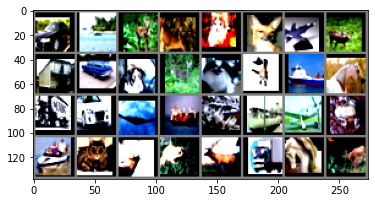

In [ ]:
# Afficher les images d'un lot
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader_subset)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

# **VGG16**

**Construction de notre modèle VGG16**

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            #nn.Linear(7*7*512, 4096),
            nn.Linear(512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

**Hyperparamètres**

In [ ]:
num_classes = 10
num_epochs = 50
batch_size = 32
learning_rate = 0.001

model = VGG16(num_classes).to(device)



# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


# Train the model
total_step = len(trainloader_subset)

**Entraînement**

In [ ]:
train_losses = []
val_losses = []
test=[]

total_step = len(trainloader_subset)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader_subset):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_losses.append(loss.item()) # Ajout de la perte d'entraînement
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0
        for images, labels in valloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() # Ajout de la perte de validation
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        #val_losses.append(val_loss/len(valloader)) # Ajout de la perte de validation moyenne
        accuracy = correct / total
        val_losses.append(accuracy)
        test.append(train_losses[-1])
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Accuracy: {accuracy:.4f}')
        del images, labels, outputs

Epoch [1/50], Train Loss: 1.9727, Validation Accuracy: 0.3330
Epoch [2/50], Train Loss: 1.5089, Validation Accuracy: 0.4533
Epoch [3/50], Train Loss: 1.6261, Validation Accuracy: 0.5180
Epoch [4/50], Train Loss: 1.1942, Validation Accuracy: 0.5813
Epoch [5/50], Train Loss: 1.1341, Validation Accuracy: 0.5843
Epoch [6/50], Train Loss: 1.1959, Validation Accuracy: 0.6213
Epoch [7/50], Train Loss: 0.8658, Validation Accuracy: 0.6680
Epoch [8/50], Train Loss: 0.8250, Validation Accuracy: 0.6620
Epoch [9/50], Train Loss: 0.9842, Validation Accuracy: 0.6760
Epoch [10/50], Train Loss: 0.7134, Validation Accuracy: 0.7083
Epoch [11/50], Train Loss: 0.5537, Validation Accuracy: 0.7090
Epoch [12/50], Train Loss: 0.6799, Validation Accuracy: 0.7327
Epoch [13/50], Train Loss: 0.7206, Validation Accuracy: 0.7340
Epoch [14/50], Train Loss: 1.0723, Validation Accuracy: 0.7390
Epoch [15/50], Train Loss: 0.6924, Validation Accuracy: 0.7357
Epoch [16/50], Train Loss: 0.3694, Validation Accuracy: 0.7510
E

In [ ]:
state = {
        'net': model.state_dict()
}

torch.save(state, 'vgg16_weights.pth')

In [ ]:
print(train_losses.index(min(test)))

2624


In [ ]:
print("La meilleure performance du modèle avec ", num_epochs,"époques correspond à une perte d'entrainement de ",min(test),"et un taux de classification de ",val_losses[test.index(min(test))],test.index(min(test)))

La meilleure performance du modèle avec  10 époques correspond à une perte d'entrainement de  1.0251843929290771 et un taux de classification de  0.5443333333333333 6


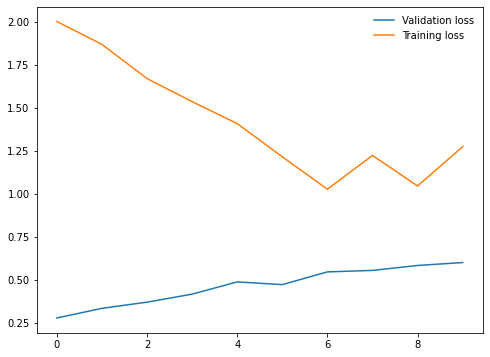

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.plot(val_losses, label='Validation loss')
plt.plot(test, label='Training loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
import plotly.express as px

# Créer un DataFrame avec les données de perte
df = pd.DataFrame({'epoch': range(num_epochs), 'train_loss': test, 'val_loss': val_losses})
# Tracer les courbes de perte d'entraînement et de validation
fig = px.line(df, x='epoch', y=['train_loss', 'val_loss'], title='Perte d\'entraînement et de validation',width=800, height=400)

# Show the figure
fig.show()

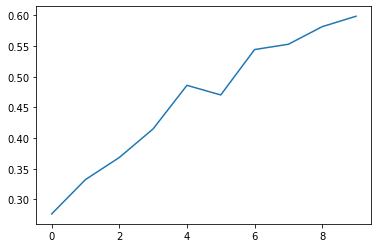

In [ ]:
plt.plot(val_losses, label='Validation loss')

**Test**

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(len(testloader.dataset), 100 * correct / total))   

Accuracy of the network on the 10000 test images: 59.11 %


# **VGG19**

**Construction du modèle**

In [ ]:
import torch
import torch.nn as nn

class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


**Hyperparamètre**

In [ ]:
# Créer les loaders de données pour l'entraînement et la validation
train_loader = trainloader_subset
test_loader = valloader

# Définir le modèle et l'envoyer sur le GPU s'il est disponible
vgg19 = VGG19()
vgg19=vgg19.to(device)

# Définir la fonction de coût et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 10

# **VGG11**

In [ ]:
class VGG11(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
# Définition du modèle VGG11
#vgg11 = VGG11(num_classes=10)
# Nombre d'époques
num_epochs = 10
num_classes = 10
batch_size = 32
learning_rate = 0.01

vgg11 = VGG11(num_classes).to(device)

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg11.parameters(), lr=0.001, momentum=0.9)

# Train the model
total_step = len(trainloader_subset)

In [ ]:
train_losses = []
val_losses = []
test=[]

total_step = len(trainloader_subset)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader_subset):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = vgg11(images)
        loss = criterion(outputs, labels)
        train_losses.append(loss.item()) # Ajout de la perte d'entraînement
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0
        for images, labels in valloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = vgg11(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() # Ajout de la perte de validation
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        #val_losses.append(val_loss/len(valloader)) # Ajout de la perte de validation moyenne
        accuracy = correct / total
        val_losses.append(accuracy)
        test.append(train_losses[-1])
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Accuracy: {accuracy:.4f}')
        del images, labels, outputs

Epoch [1/10], Train Loss: 2.3026, Validation Accuracy: 0.0983
Epoch [2/10], Train Loss: 2.3082, Validation Accuracy: 0.1013
Epoch [3/10], Train Loss: 2.3020, Validation Accuracy: 0.1013
Epoch [4/10], Train Loss: 2.3000, Validation Accuracy: 0.1013


KeyboardInterrupt: ignored

# **Part3**

# **test**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import os

# Charger les données
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'path/to/dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join('./data', x), data_transforms[x])
                  for x in ['train', 'val']}
#image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Charger le modèle pré-entraîné
vgg16 = models.vgg16(pretrained=True)

# Geler les paramètres des couches convolutives
for param in vgg16.features.parameters():
    param.requires_grad = False

# Redéfinir la couche entièrement connectée pour notre tâche de classification binaire
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Supprimer la dernière couche linéaire
features.extend([nn.Linear(num_features, 2)]) # Ajouter notre propre couche linéaire
vgg16.classifier = nn.Sequential(*features)

# Définir les critères de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)

# Entraîner le modèle sur nos propres données
num_epochs = 10
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            vgg16.train()  # Mettre le modèle en mode entraînement
        else:
            vgg16.eval()   # Mettre le modèle en mode évaluation

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Remettre à zéro les gradients des paramètres de l'optimiseur
            optimizer.zero_grad()

            # Calculer les sorties du modèle
            with torch.set_grad_enabled(phase == 'train'):
                outputs = vgg16(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Rétropropager les gradients et mettre à jour les poids si en mode entraînement
                if phase == 'train':
                    loss.backward
                    optimizer.step()

            # Mettre à jour les statistiques
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

# Sauvegarder le modèle
#torch.save(vgg16.state_dict(), 'vgg16_finetuned.pth')

# **Transfer learning**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models

# Load pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze all pre-trained layers
for param in vgg16.parameters():
    param.requires_grad = False

# Modify the last layer to fit new number of classes
num_classes = 10
vgg16.classifier[-1] = nn.Linear(4096, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

# Load new dataset
'''train_dataset = datasets.ImageFolder('train', transform=transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))'''
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)




In [ ]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()